В данном ноутбуке можно посчитать семейство орбит Ляпунова для заданной системы. Сохранить посчитанные данные в файл.
Для отдельно взятой орбиты возможно нарисовать устойчивое и неустойчивое многообразие

In [1]:
import numpy as np
from scipy import optimize, interpolate
import scipy
import os

import matplotlib.pyplot as plt

from crtbp_planar_prop import propCrtbp, prop2Limits, findVLimits,findVLimits_debug
# ОСТОРОЖНО! findVLimits_debug сохраняет кучу картинок
from lagrange_pts import lagrange1, lagrange2
from stop_funcs import stopFunCombined, iVarX, iVarY, iVarAlpha

%matplotlib inline

In [2]:
# префикс для имен файлов (для сохраняемых картинок и прочего)
NAME = 'EML2 '

In [3]:
Sm =  1.9891e30 # mass of the Sun
Em =  5.97e24 # mass of the Earth
Mm =  7.34767e22 # mass of the Moon
ER =  1.496e8 # Sun-Earth distance
ME =  384400
#mu2 = Em / (Sm + Em) # CRTBP main coefficient

mu2 = 0.0121505856  # Mm/(Em+Mm)

mu1 = 1-mu2

L = [lagrange1(mu2), lagrange2(mu2)] # L1, L2 positions


rtol = 1e-12 # integration relative tolerance
nmax = 1e6 # max number of integration steps
int_param = {'atol':rtol, 'rtol':rtol, 'nsteps':nmax}

In [ ]:
plt.scatter([L[0], L[1], 1-mu2], [0, 0, 0])

In [4]:
# события для EML2
eventA = {'ivar':iVarAlpha, 'stopval': np.deg2rad(160), 'direction':0, 'isterminal':True, 'corr':False, 'kwargs':{'center':mu1}}
eventB = {'ivar':iVarAlpha, 'stopval': np.deg2rad(-160), 'direction':0, 'isterminal':True, 'corr':False, 'kwargs':{'center':mu1}}
eventR = {'ivar':iVarX, 'stopval':   L[1]+150000/ME, 'direction':0, 'isterminal':True,  'corr':False}
eventL = {'ivar':iVarX, 'stopval':   L[0]-150000/ME, 'direction':0, 'isterminal':True,  'corr':False}
eventY = {'ivar':iVarY, 'stopval':   -0.8, 'direction':0, 'isterminal':True,  'corr':False}
eventYUP = {'ivar':iVarY, 'stopval':   0.8, 'direction':0, 'isterminal':True,  'corr':False}
eventYcross = {'ivar':iVarY, 'stopval':   0, 'direction': 0, 'isterminal':False,  'corr':True}
eventYStop = {'ivar':iVarY, 'stopval':   0, 'direction': 1, 'isterminal':True,  'corr':True}
lims = {'left':[eventA, eventB], 'right':[eventR, eventY]}

Если ранее для выбранной системы уже было посчитано семейство орбит Ляпунова, то выполнить следующие две ячейки
Возможно, надо будет изменить номер загружаемого файла

In [5]:
files = [f for f in os.listdir('.') if f.endswith('.txt') and f.startswith(NAME)]
files

['EML2 lyapunov N = 51.txt']

In [6]:
xy = np.loadtxt(files[0], dtype=np.float64, delimiter='\t')

поиск начальных условия для орбит ляпунова
очень маленькие (близкие к l2) не считаются, думаю, что нужно точнее регулировать ограничения, особенно левое

In [ ]:
lst = []
N = 51
x0 = np.linspace(1.1557, 1.0, N)
y0 = np.array([x0[0], 0, 0, 0])
y0[2:4] += findVLimits(mu1, y0, 90, lims, 0.1, int_param=int_param)
lst.append(y0)
for x in x0[1:]:
    if len(lst) > 2:
        f = interpolate.interp1d([lst[-1][0], lst[-2][0]], [lst[-1][3], lst[-2][3]], fill_value='extrapolate' )
        y0 = np.array([x, 0, 0, f(x)])
    else:
        y0 = np.array([x, 0, 0, lst[-1][3]])
    y0[2:4] += findVLimits(mu1, y0, 90, lims, 0.1, int_param=int_param)
    lst.append(y0)
    print(y0)

In [ ]:
# сохранить посчитанное семейство для следующего раза
xy = np.array(lst)
np.savetxt(NAME + 'lyapunov N = {0}'.format(str(N)) + '.txt', xy, fmt='%.18e', delimiter='\t', newline='\n')

для отладки

In [ ]:
y0 = np.array([ 1.0194625 ,  0.        ,  0.        ,  0.84713697])
findVLimits_debug(mu1, y0, 90, lims, 0.1, int_param=int_param)

In [ ]:
findVLimits_debug(mu1, y0, 90, lims, 0.1, int_param=int_param)

как меняется начальная скорость по y от начального x, и синим нарисована производная

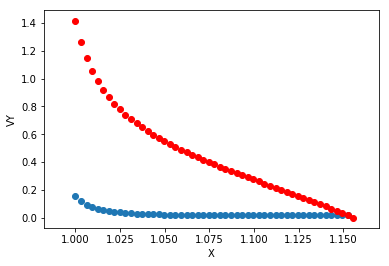

In [7]:
plt.scatter(xy[1:,0], xy[1:,3]-xy[:-1,3])
plt.scatter(xy[:,0], xy[:,3], color='red')
plt.xlabel('X')
plt.ylabel('VY')

<h1>Многообразия для одной орбиты Ляпунова</h1>

In [8]:
# чтобы заново не считать, раскомментировать следущую строку и закомментировать следующую через одну
#y0 = np.array([  1.14013000e+00,   0.00000000e+00,  -1.36423389e-20, 8.05146317e-02])
y0 = xy[50, :].copy()
evout = []
arr = propCrtbp(mu1, y0, [0, 5*np.pi], stopf=stopFunCombined, events = [eventYStop], out=evout, int_param=int_param)

(0.79781300368970154,
 1.3239654135680081,
 -0.53678068581301996,
 0.5367800588948306)

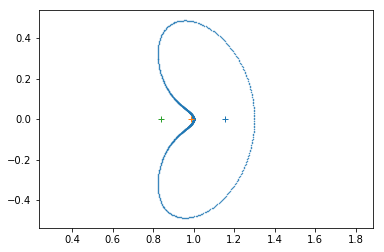

In [9]:
# построение выбранной орбиты
plt.scatter(arr[:,0],arr[:,1], s=0.2)
plt.plot(L[1], 0, '+')
plt.plot(1-mu2, 0, '+')
plt.plot(L[0], 0, '+')
plt.axis('equal')

In [10]:
# интерполируется орбита, чтобы равномерно были распределены точки по ней 
l = np.cumsum(np.linalg.norm(arr[1:,:2]-arr[:-1,:2], axis=1))
intrp = scipy.interpolate.interp1d(l, arr[1:,:4], axis=0, kind='cubic', copy=False)#, assume_sorted=False)
ls = np.linspace(l[0], l[-1], 200)
orb = intrp(ls)

(0.79781492953338118,
 1.3239338298354228,
 -0.53673050403435996,
 0.53672463880430032)

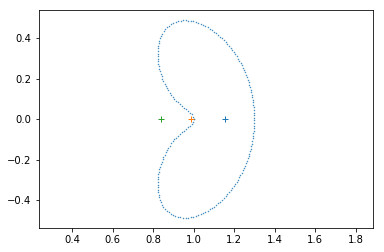

In [11]:
# отрисовывается проинтерполированная орбита
plt.scatter(orb[:,0], orb[:,1], s=0.2)
plt.plot(L[1], 0, '+')
plt.plot(1-mu2, 0, '+')
plt.plot(L[0], 0, '+')
plt.axis('equal')

In [12]:
# расчет многообразий
# по оси x дается импульс постоянный по величине
manifold = []
manifold_stable = []
man_evout = []
for y1 in orb:
    evout = []
    y0 = y1.copy()
    y0[2] += 1e-5 #np.sqrt(y0[2]**2 + y0[3]**2)*1e-5
    
    #arr = propCrtbp(mu1, y0, [0, 4*np.pi],stopf=stopFunCombined, events =\
    #                [eventL, eventR, eventY, eventYUP], out= evout, int_param=int_param)
    arr = propCrtbp(mu1, y0, [0, 5.3*np.pi],int_param=int_param)
    manifold.append(arr)
    #arr = propCrtbp(mu1, y0, [0, -4*np.pi],stopf=stopFunCombined, events =\
    #            [eventL, eventR, eventY, eventYUP], out= evout, int_param=int_param)
    arr = propCrtbp(mu1, y0, [0, -5*np.pi],int_param=int_param)
    manifold_stable.append(arr)
    
    y0[2] -= 2e-5 #np.sqrt(y0[2]**2 + y0[3]**2)*1e-5
    
    #arr = propCrtbp(mu1, y0, [0, 4*np.pi],stopf=stopFunCombined, events =\
    #            [eventL, eventR, eventY, eventYUP], out= evout, int_param=int_param)
    arr = propCrtbp(mu1, y0, [0, 5*np.pi],int_param=int_param)
    manifold.append(arr)
    #arr = propCrtbp(mu1, y0, [0, -4*np.pi],stopf=stopFunCombined, events =\
    #            [eventL, eventR, eventY, eventYUP], out= evout, int_param=int_param)
    arr = propCrtbp(mu1, y0, [0, -5.3*np.pi],int_param=int_param)
    manifold_stable.append(arr)


C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


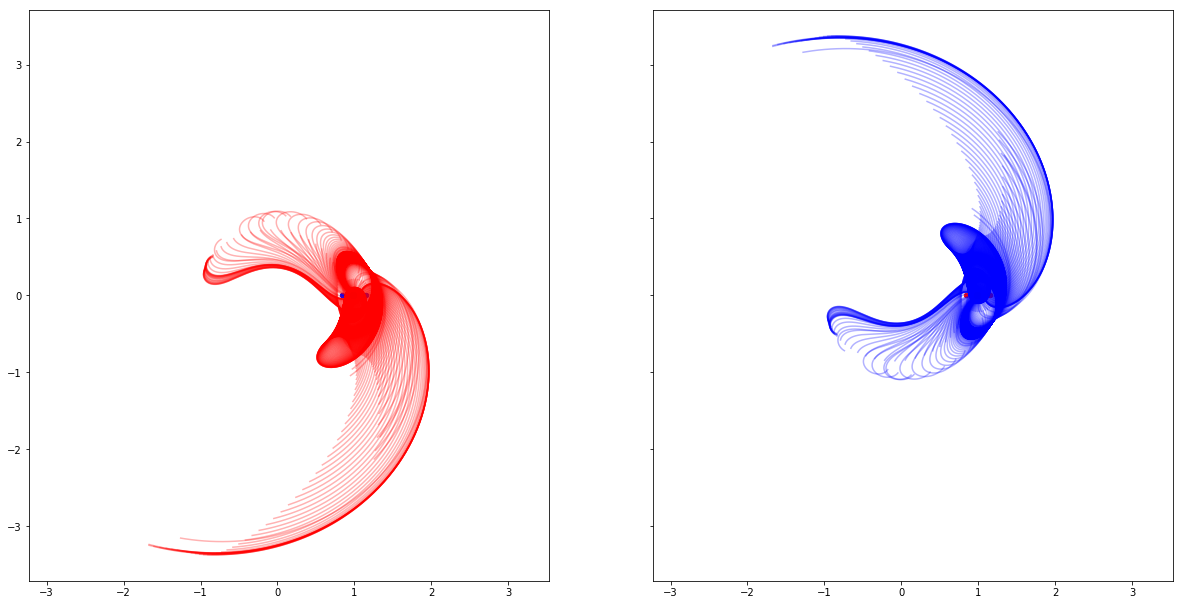

In [13]:
# отрисовка многообразий, устойчивое и не устойчивое на разных графиках
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for y in manifold:
    ax1.plot(y[:,0], y[:,1], 'r', alpha=0.3)
    
for y in manifold_stable:
    ax2.plot(y[:,0], y[:,1], 'b', alpha=0.3)

ax1.scatter(L[1], 0, s=20, c='blue')
ax1.scatter(1-mu2, 0, s=30, c='k')
ax1.scatter(L[0], 0, s=20, c='blue')
ax1.axis('equal')   

ax2.scatter(L[1], 0, s=20, c='r')
ax2.scatter(1-mu2, 0, s=30, c='k')
ax2.scatter(L[0], 0, s=20, c='r')
ax2.axis('equal')  
    
#fig = plt.gcf()
f.set_size_inches(20.5, 10.5)
f.savefig(NAME+'manifolds 2.png', dpi=300)

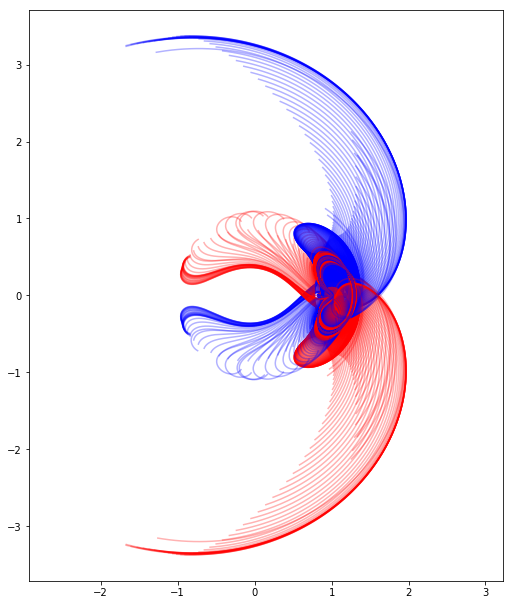

In [14]:
# отрисовка многообразий, устойчивое и не устойчивое на одном графике
for i in range(len(manifold)):
    plt.plot(manifold[i][:,0], manifold[i][:,1], 'r', alpha=0.3)
    plt.plot(manifold_stable[i][:,0], manifold_stable[i][:,1], 'b', alpha=0.3)

plt.scatter(L[1], 0, s=20, c='blue')
plt.scatter(1-mu2, 0, s=30, c='k')
plt.scatter(L[0], 0, s=20, c='blue')
plt.axis('equal')    
    
fig = plt.gcf()
fig.set_size_inches(8.5, 10.5)
fig.savefig(NAME+'manifolds.png', dpi=300)